# **AutoEncoder Synthetic Anomaly (Shovel + Hammer)**

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, precision_recall_fscore_support,
                             confusion_matrix, roc_curve, ConfusionMatrixDisplay)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Dataset 

In [2]:
# Paths to audio files
anomalous_audio_path = "../../Data/raw/11_A_09_experiment7/A_09_10_experiment7_8.wav"
normal_audio_path = "../../Data/raw/11_A_09_experiment7/N_09_experiment7.wav"

# Paths for saving frames and datasets
output_anomalous_frames_path = "../../Data/frames/anomalous_frames_synthetic.npy"
output_normal_frames_path = "../../Data/frames/normal_frames_synthetic.npy"
train_frames_path = "../../Data/datasets/train_frames_synthetic.npy"
val_frames_path = "../../Data/datasets/val_frames_synthetic.npy"
test_frames_path = "../../Data/datasets/test_frames_synthetic.npy"
test_labels_path = "../../Data/datasets/test_labels_synthetic.npy"

# Ensure necessary directories exist
os.makedirs(os.path.dirname(output_anomalous_frames_path), exist_ok=True)
os.makedirs(os.path.dirname(train_frames_path), exist_ok=True)

## Spectrogram and Frames Generation

In [3]:
# Function to generate a normalized Mel-spectrogram
def generate_mel_spectrogram(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)
    stft = librosa.stft(audio, n_fft=1024, hop_length=512)
    mel = librosa.feature.melspectrogram(S=np.abs(stft)**2, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # Normalize to [0, 1]
    mel_db_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    return mel_db_norm, sr

# Generate Mel-spectrograms
mel_db_anomalous, sr_anomalous = generate_mel_spectrogram(anomalous_audio_path)
mel_db_normal, sr_normal = generate_mel_spectrogram(normal_audio_path)

# Ensure sampling rates match
assert sr_anomalous == sr_normal, "Sampling rates do not match!"

# Function to generate overlapping frames from a Mel-spectrogram
def generate_frames(mel_spectrogram, frame_size, hop_size):
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))
    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]
    return frames

# Adjustable parameters
time_per_frame = 0.6  # Duration of one frame in seconds
hop_ratio = 0.2       # Overlap ratio between frames

# Calculate frame and hop sizes
hop_length = 512
frame_size = int((time_per_frame * sr_anomalous) / hop_length)
hop_size = int(frame_size * hop_ratio)

# Generate frames
anomalous_frames = generate_frames(mel_db_anomalous, frame_size, hop_size)
normal_frames = generate_frames(mel_db_normal, frame_size, hop_size)

# Save frames
np.save(output_anomalous_frames_path, anomalous_frames)
np.save(output_normal_frames_path, normal_frames)

## Train and Test Splits

In [4]:
# Load frames
anomalous_frames = np.load(output_anomalous_frames_path)
normal_frames = np.load(output_normal_frames_path)

# Split normal frames into training, validation, and test sets
normal_train_val, normal_test = train_test_split(normal_frames, test_size=0.15, random_state=42)
normal_train, normal_val = train_test_split(normal_train_val, test_size=0.1765, random_state=42)  # Approximately 15% of total normal data

# Combine normal_test and anomalous_frames for testing
test_frames = np.concatenate([normal_test, anomalous_frames], axis=0)
test_labels = np.concatenate([np.zeros(len(normal_test)), np.ones(len(anomalous_frames))])

# Shuffle the test set
indices = np.arange(len(test_frames))
np.random.shuffle(indices)
test_frames = test_frames[indices]
test_labels = test_labels[indices]

# Save datasets
np.save(train_frames_path, normal_train)
np.save(val_frames_path, normal_val)
np.save(test_frames_path, test_frames)
np.save(test_labels_path, test_labels)

# Load datasets for training
train_frames = np.load(train_frames_path)
val_frames = np.load(val_frames_path)

# Convert to PyTorch tensors
train_frames_tensor = torch.tensor(train_frames, dtype=torch.float32)
val_frames_tensor = torch.tensor(val_frames, dtype=torch.float32)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(train_frames_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_frames_tensor), batch_size=batch_size)


## AE Model Implementation

In [5]:
# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        flattened_size = input_shape[0] * input_shape[1]
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, flattened_size),
            nn.Sigmoid(),
            nn.Unflatten(1, input_shape)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## AE Training

Epoch 1/10, Training Loss: 0.0581, Validation Loss: 0.0554
Epoch 2/10, Training Loss: 0.0418, Validation Loss: 0.0228
Epoch 3/10, Training Loss: 0.0119, Validation Loss: 0.0054
Epoch 4/10, Training Loss: 0.0037, Validation Loss: 0.0028
Epoch 5/10, Training Loss: 0.0025, Validation Loss: 0.0024
Epoch 6/10, Training Loss: 0.0023, Validation Loss: 0.0022
Epoch 7/10, Training Loss: 0.0022, Validation Loss: 0.0022
Epoch 8/10, Training Loss: 0.0022, Validation Loss: 0.0022
Epoch 9/10, Training Loss: 0.0022, Validation Loss: 0.0022
Epoch 10/10, Training Loss: 0.0021, Validation Loss: 0.0021


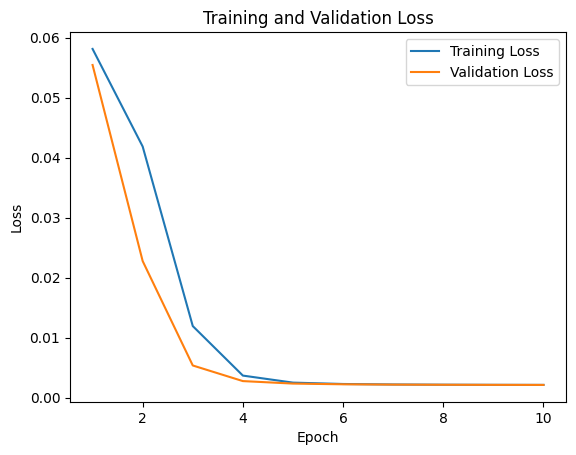

Autoencoder model saved to AE_Synthetic.pth


In [6]:
# Initialize the model
input_shape = train_frames_tensor.shape[1:]
autoencoder = Autoencoder(input_shape)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

# Training loop with loss tracking
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    autoencoder.train()
    train_loss = 0.0
    for inputs in train_loader:
        inputs = inputs[0]  # Unpack the tuple
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in val_loader:
            inputs = inputs[0]  # Unpack the tuple
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Plot training and validation loss over epochs
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the trained model
torch.save(autoencoder.state_dict(), "../../Models/AutoEncoder/AE_Synthetic.pth") 
print("Autoencoder model saved to AE_Synthetic.pth")

## Evaluation and Thresholding

### Note: 
Higher recall (less false negatives) is aimed for as missed anomalies are costly in our use case. The threshold percentile can be adjusted accordingly (lower threshold improves recall) 

Threshold for anomaly detection set at: 0.0024015128146857023
ROC AUC Score: 0.9989
Precision: 0.9734, Recall: 0.9972, F1-Score: 0.9852
Confusion Matrix:
[[ 941   49]
 [   5 1795]]


/var/folders/rh/swfvk_zs36s3zmd3j2nmq0kw0000gn/T/ipykernel_12754/1794983466.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("../..

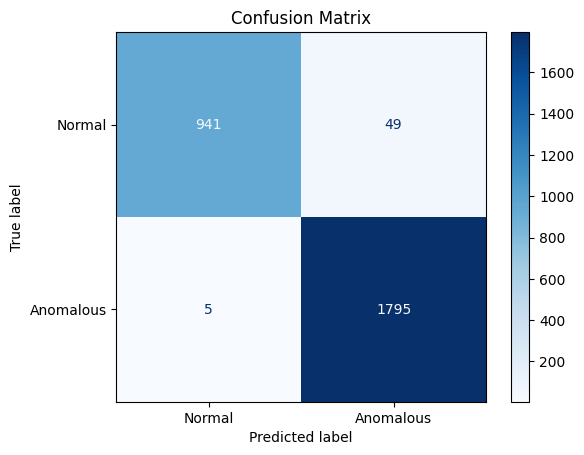

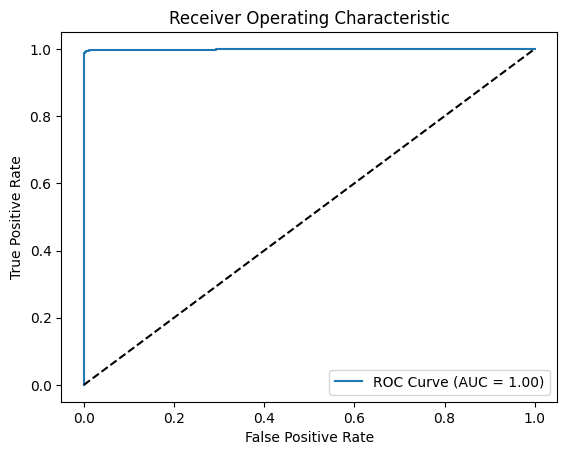

In [7]:
test_frames = np.load(test_frames_path)
test_labels = np.load(test_labels_path)

# Convert test frames to PyTorch tensor
test_frames_tensor = torch.tensor(test_frames, dtype=torch.float32)

# Load the trained autoencoder model
autoencoder.load_state_dict(torch.load("../../Models/AutoEncoder/AE_Synthetic.pth"))
autoencoder.eval()

# Compute reconstruction errors on the validation set
with torch.no_grad():
    val_reconstructions = autoencoder(val_frames_tensor)
    val_losses_tensor = nn.functional.mse_loss(val_reconstructions, val_frames_tensor, reduction='none')
    val_losses_array = val_losses_tensor.view(val_losses_tensor.size(0), -1).mean(dim=1).numpy()

# Set threshold based on validation losses (96th percentile)
threshold = np.percentile(val_losses_array, 96)
print(f"Threshold for anomaly detection set at: {threshold}")

# Compute reconstruction errors on the test set
with torch.no_grad():
    test_reconstructions = autoencoder(test_frames_tensor)
    test_losses_tensor = nn.functional.mse_loss(test_reconstructions, test_frames_tensor, reduction='none')
    test_losses = test_losses_tensor.view(test_losses_tensor.size(0), -1).mean(dim=1).numpy()

# Predict anomalies
predictions = (test_losses > threshold).astype(int)

# Evaluate performance
roc_auc = roc_auc_score(test_labels, test_losses)
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predictions, average='binary')
conf_matrix = confusion_matrix(test_labels, predictions)

print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomalous'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, test_losses)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Correctly Classified Anomalies:


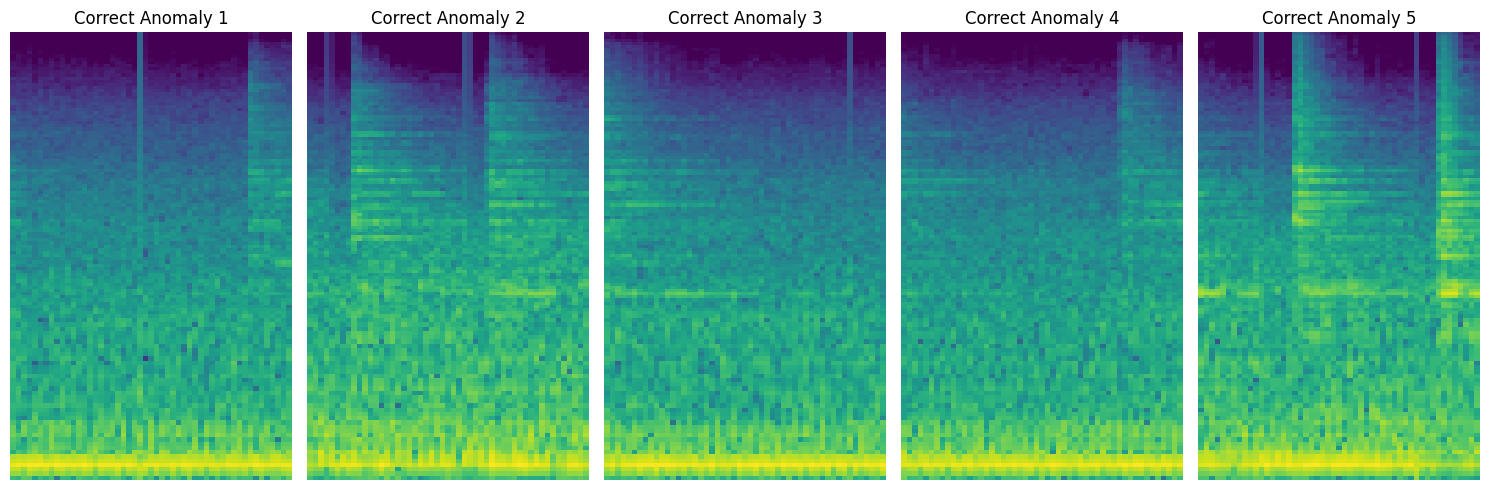

Wrongly Classified Anomalies:


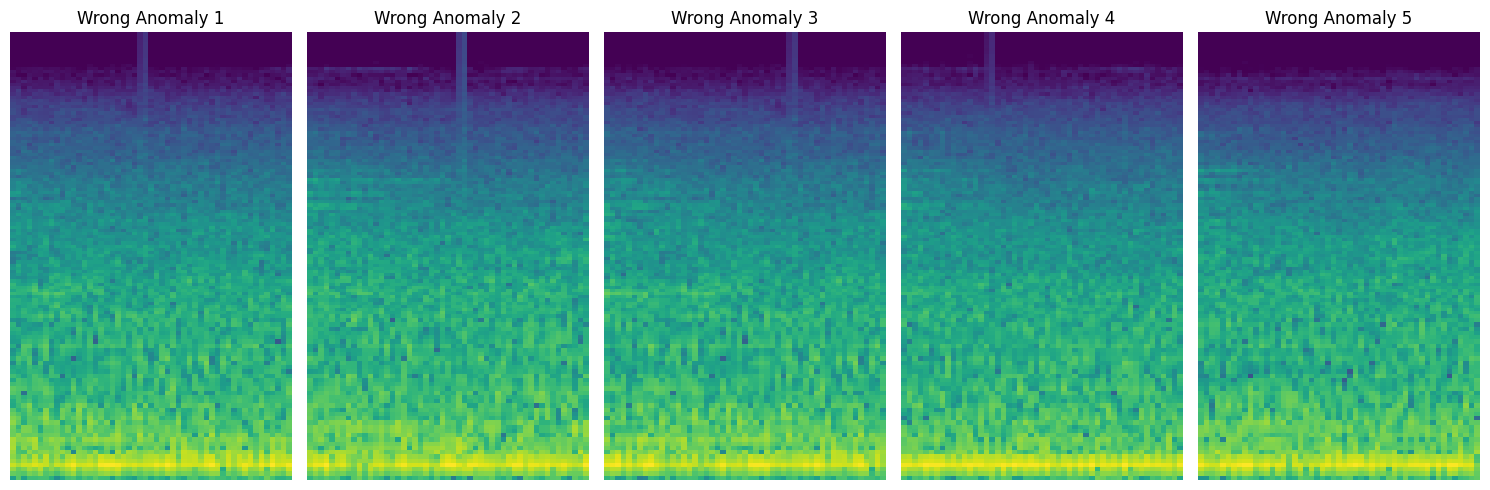

Wrongly Classified Normal Frames:


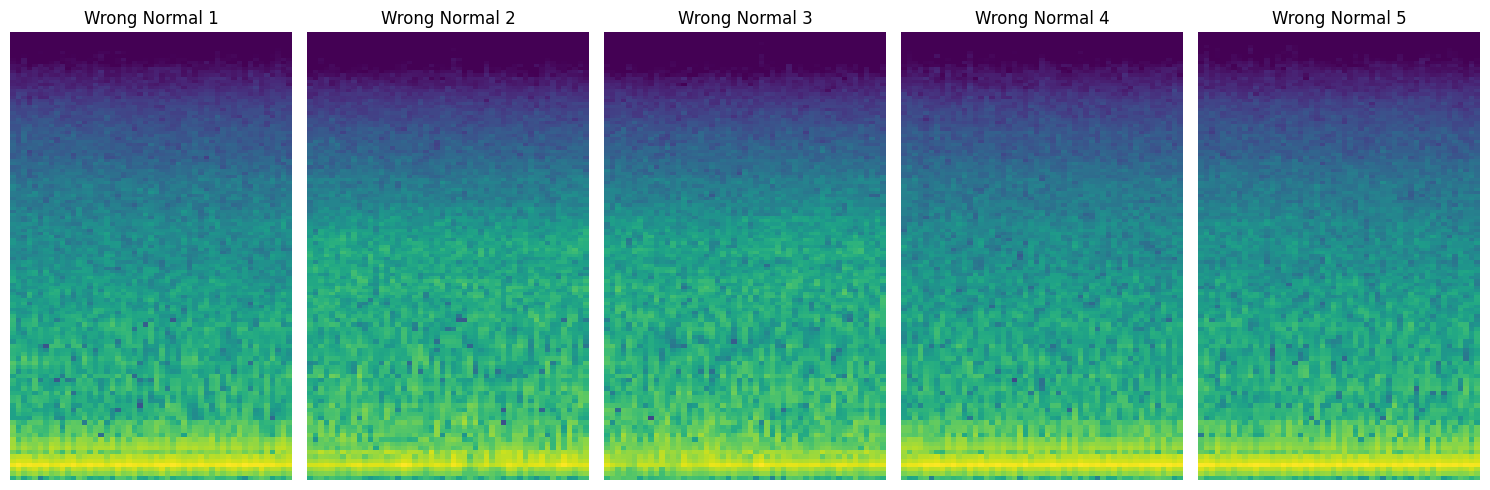

In [8]:
# Identify indices
correctly_classified_anomalies = np.where((test_labels == 1) & (predictions == 1))[0]
wrongly_classified_anomalies = np.where((test_labels == 1) & (predictions == 0))[0]
wrongly_classified_normals = np.where((test_labels == 0) & (predictions == 1))[0]

# Select up to 5 samples from each category
num_samples = 5
correct_anomaly_indices = correctly_classified_anomalies[:num_samples]
wrong_anomaly_indices = wrongly_classified_anomalies[:num_samples]
wrong_normal_indices = wrongly_classified_normals[:num_samples]

# Function to plot specified frames
def plot_specified_frames(frames, indices, title_prefix="Frame"):
    num_frames = len(indices)
    if num_frames == 0:
        print(f"No frames to plot for {title_prefix}.")
        return
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    if num_frames == 1:
        axes = [axes]
    for i, idx in enumerate(indices):
        ax = axes[i]
        img = librosa.display.specshow(frames[idx], x_axis=None, y_axis="mel", cmap="viridis", ax=ax)
        ax.set_title(f"{title_prefix} {i+1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

print("Correctly Classified Anomalies:")
plot_specified_frames(test_frames, correct_anomaly_indices, title_prefix="Correct Anomaly")

print("Wrongly Classified Anomalies:")
plot_specified_frames(test_frames, wrong_anomaly_indices, title_prefix="Wrong Anomaly")

print("Wrongly Classified Normal Frames:")
plot_specified_frames(test_frames, wrong_normal_indices, title_prefix="Wrong Normal")

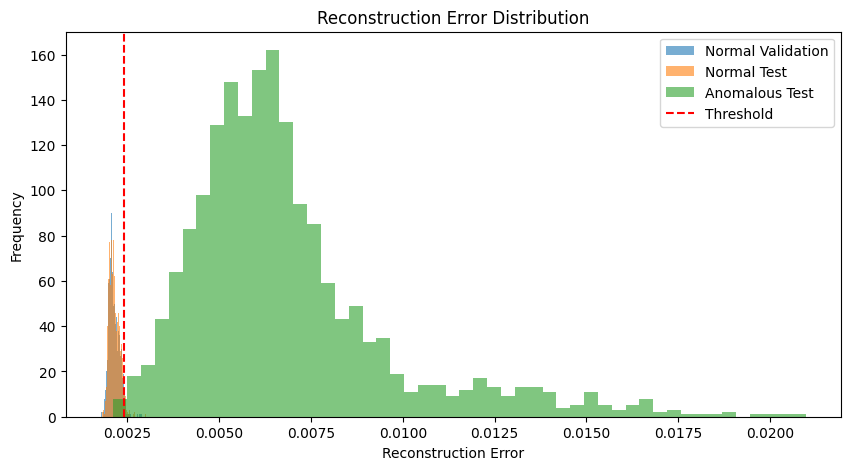

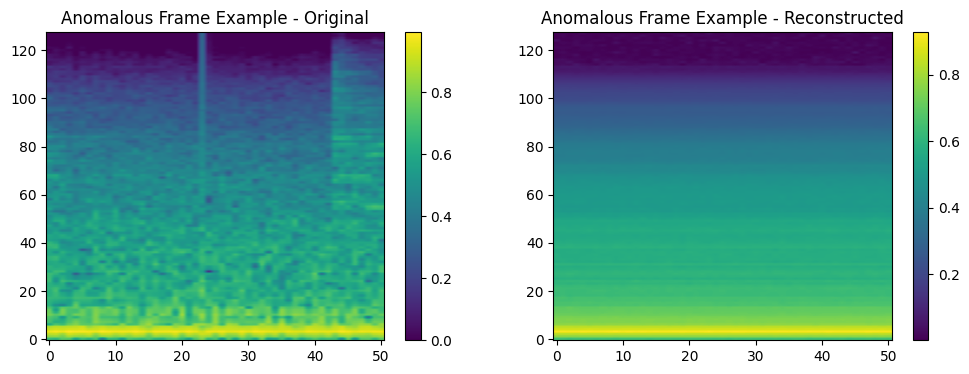

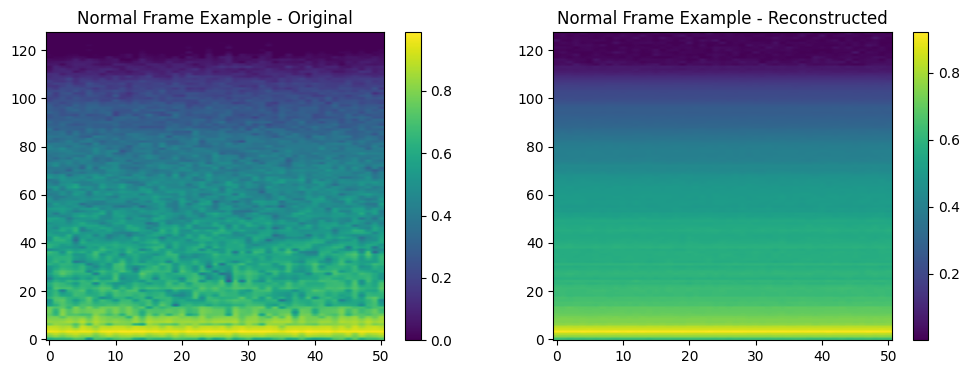

In [10]:
# Reconstruction error distribution for validation (normal) and test sets
test_losses_normal = test_losses[test_labels == 0]
test_losses_anomalous = test_losses[test_labels == 1]

plt.figure(figsize=(10, 5))
plt.hist(val_losses_array, bins=50, alpha=0.6, label='Normal Validation')
plt.hist(test_losses_normal, bins=50, alpha=0.6, label='Normal Test')
plt.hist(test_losses_anomalous, bins=50, alpha=0.6, label='Anomalous Test')
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Function to visualize original vs reconstructed frames
def plot_original_vs_reconstructed(original, reconstructed, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"{title} - Original")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"{title} - Reconstructed")
    plt.colorbar()
    plt.show()

# Visualize one anomalous frame (original vs reconstructed)
anomalous_indices = np.where(test_labels == 1)[0]
if len(anomalous_indices) > 0:
    anomalous_frame_index = anomalous_indices[0]  # Take the first anomalous frame
    anomalous_original_frame = test_frames[anomalous_frame_index]
    anomalous_reconstructed_frame = test_reconstructions[anomalous_frame_index].detach().cpu().numpy()

    plot_original_vs_reconstructed(anomalous_original_frame, anomalous_reconstructed_frame, "Anomalous Frame Example")
else:
    print("No anomalous frames found to visualize.")

# Visualize one normal frame (original vs reconstructed)
normal_indices = np.where(test_labels == 0)[0]
if len(normal_indices) > 0:
    normal_frame_index = normal_indices[0]  # Take the first normal frame
    normal_original_frame = test_frames[normal_frame_index]
    normal_reconstructed_frame = test_reconstructions[normal_frame_index].detach().cpu().numpy()

    plot_original_vs_reconstructed(normal_original_frame, normal_reconstructed_frame, "Normal Frame Example")
else:
    print("No normal frames found to visualize.")